In [158]:
import psycopg2
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import re

In [134]:
pd.set_option('display.max_rows', 200)

In [89]:
connection = psycopg2.connect(
    user = "postgres", 
    password = "docker", 
    host = "localhost", 
    port = "5432", 
    database = "postgres"
)
cursor = connection.cursor()

In [90]:
resp = cursor.execute("SELECT count(*) FROM performance;")
record = cursor.fetchone()
assert record[0] > 0

In [237]:
cursor.execute("""
    SELECT 
        perf.*,
        news.title,
        news.content,
        news.time
    FROM performance perf
    JOIN news 
        ON news.url = perf.url
    WHERE perf.performance IS NOT NULL
;""")
records = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
perf_df = pd.DataFrame(records, columns=columns)
perf_df.sample(3)

,url,strategy,symbol,performance,extractor,title,content,time
367,https://binance.zendesk.com/hc/en-us/articles/...,charly_S30W5L5,BNBUSDT,-0.043950,onlyBnb,"WTC Trading Competition, $85,000 in WTC Tokens...",Binance and Waltonchain are collaborating to o...,2020-04-16 11:55:12+00:00
1905,https://binance.zendesk.com/hc/en-us/articles/...,charly_S10W5L5,BTCUSDT,0.200207,relatedAgainstUsdt,Notice of Removal of Trading Pairs - 2020/04/24,"Fellow Binancians,\nBinance will remove and ce...",2020-04-23 11:22:54+00:00
825,https://binance.zendesk.com/hc/en-us/articles/...,highestStrategy,ALGOBNB,1.002313,relatedAgainstBnb,Binance Has Distributed First Batch of March S...,"Fellow Binancians,\nBinance has completed the ...",2020-04-10 10:51:16+00:00


In [260]:
meaningless_words = ['to', 'and', 'will', 'of', 'the', 'for', 'on', '', 'by', 'a', 'an', 'as', 'in', 'be', 'has', 'have']
def format_title(title):
    clean_title = re.sub('[^A-Za-z0-9 ]+', ' ', title.lower())
    without_duplicate_space_title = re.sub(' +', ' ',clean_title)
    words = clean_title.split(' ')
    uniq_words = list(set(words))
    meaningful_words = [word for word in uniq_words if word not in meaningless_words]
    return meaningful_words

In [263]:
word_df = perf_df.copy()
word_df['words'] = word_df['title'].apply(format_title)

url            https://binance.zendesk.com/hc/en-us/articles/...
strategy                                              follower10
symbol                                                   ATOMBNB
performance                                             0.066313
extractor                                      relatedAgainstBnb
title            Notice of Removal of Trading Pairs - 2020/04/24
content        Fellow Binancians,\nBinance will remove and ce...
time                                   2020-04-23 11:22:54+00:00
words            [trading, 24, notice, 04, pairs, removal, 2020]
Name: 1963, dtype: object

In [264]:
words_exploded_df = word_df \
    .explode('words') \
    .groupby(['words', 'extractor', 'strategy', 'symbol']) \
    .agg(
        count=('words', 'count'), 
        computed_perf=('performance', 'mean')
    )

In [265]:
words_exploded_df.sample(20)

,,,,count,computed_perf
words,extractor,strategy,symbol,,
launchpad,onlyBnb,wait15Minutes,BNBUSDT,1,3.187720
binance,relatedAgainstUsdt,follower5,ZECUSDT,1,-0.246637
idrt,relatedAgainstUsdt,charly_S30W5L5,BUSDUSDT,1,0.010012
leveraged,relatedAgainstUsdt,wait15Minutes,BNBBULLUSDT,1,0.337458
march,relatedAgainstBnb,follower10,ERDBNB,1,0.551789
04,relatedAgainstUsdt,follower0_5,COCOSUSDT,1,-0.684932
launch,onlyBnb,follower2,BNBUSDT,1,1.304434
march,relatedAgainstBnb,follower0_5,VETBNB,1,0.430866
03,relatedAgainstUsdt,charly_S10W5L5,ADAUSDT,1,0.159337


In [301]:
array = words_exploded_df.reset_index()
strategyFilter = array['strategy'] == 'highestStrategy'
extractorFilter =  array['extractor'] == 'onlyBnb'
filtered_array = array[strategyFilter & extractorFilter].sort_values(['computed_perf'], ascending=False)
filtered_array.head(100)

,words,extractor,strategy,symbol,count,computed_perf
6498,introducing,onlyBnb,highestStrategy,BNBUSDT,1,6.473633
6738,launchpad,onlyBnb,highestStrategy,BNBUSDT,1,6.473633
10188,rupiah,onlyBnb,highestStrategy,BNBUSDT,1,5.017764
6438,idrt,onlyBnb,highestStrategy,BNBUSDT,1,5.017764
1568,25,onlyBnb,highestStrategy,BNBUSDT,1,3.494757
11418,system,onlyBnb,highestStrategy,BNBUSDT,1,3.494757
12318,upgrade,onlyBnb,highestStrategy,BNBUSDT,1,3.494757
10238,sale,onlyBnb,highestStrategy,BNBUSDT,2,3.398109
11458,token,onlyBnb,highestStrategy,BNBUSDT,4,3.141410
6938,list,onlyBnb,highestStrategy,BNBUSDT,3,2.142455


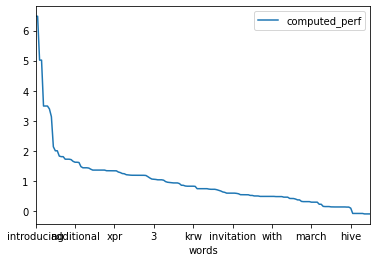

In [300]:
filtered_array.plot(x='words', y='computed_perf')